In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest

Descriptive Statistics on Pollutants and AQI

In [14]:
df = pd.read_csv(r"C:\Users\VICTUS\OneDrive\Desktop\CA2 py.csv")

print("Dataset Info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

pollutant_columns = ['pollutant_min', 'pollutant_max', 'pollutant_avg']
df_pollutants = df[pollutant_columns]

print("\nPollutants and AQI Statistics:")
print(df_pollutants.describe())

df_clean = df.dropna(subset=['pollutant_avg'])

print("\nAvg Pollution in First 5 Cities (No NaNs):")
a = df_clean.groupby('city')['pollutant_avg'].unique().head(5)
print(a)

print("\nAvg Pollution in Last 5 Cities (No NaNs):")
b = df_clean.groupby('city')['pollutant_avg'].unique().tail(5)
print(b)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        3222 non-null   object 
 1   state          3222 non-null   object 
 2   city           3222 non-null   object 
 3   station        3222 non-null   object 
 4   last_update    3222 non-null   object 
 5   latitude       3222 non-null   float64
 6   longitude      3222 non-null   float64
 7   pollutant_id   3222 non-null   object 
 8   pollutant_min  2848 non-null   float64
 9   pollutant_max  2848 non-null   float64
 10  pollutant_avg  2848 non-null   float64
dtypes: float64(5), object(6)
memory usage: 277.0+ KB
None

Descriptive Statistics:
          latitude    longitude  pollutant_min  pollutant_max  pollutant_avg
count  3222.000000  3222.000000    2848.000000    2848.000000    2848.000000
mean     22.187169    78.710509      21.364466      75.931180      41

Visualize Distribution of Pollutants

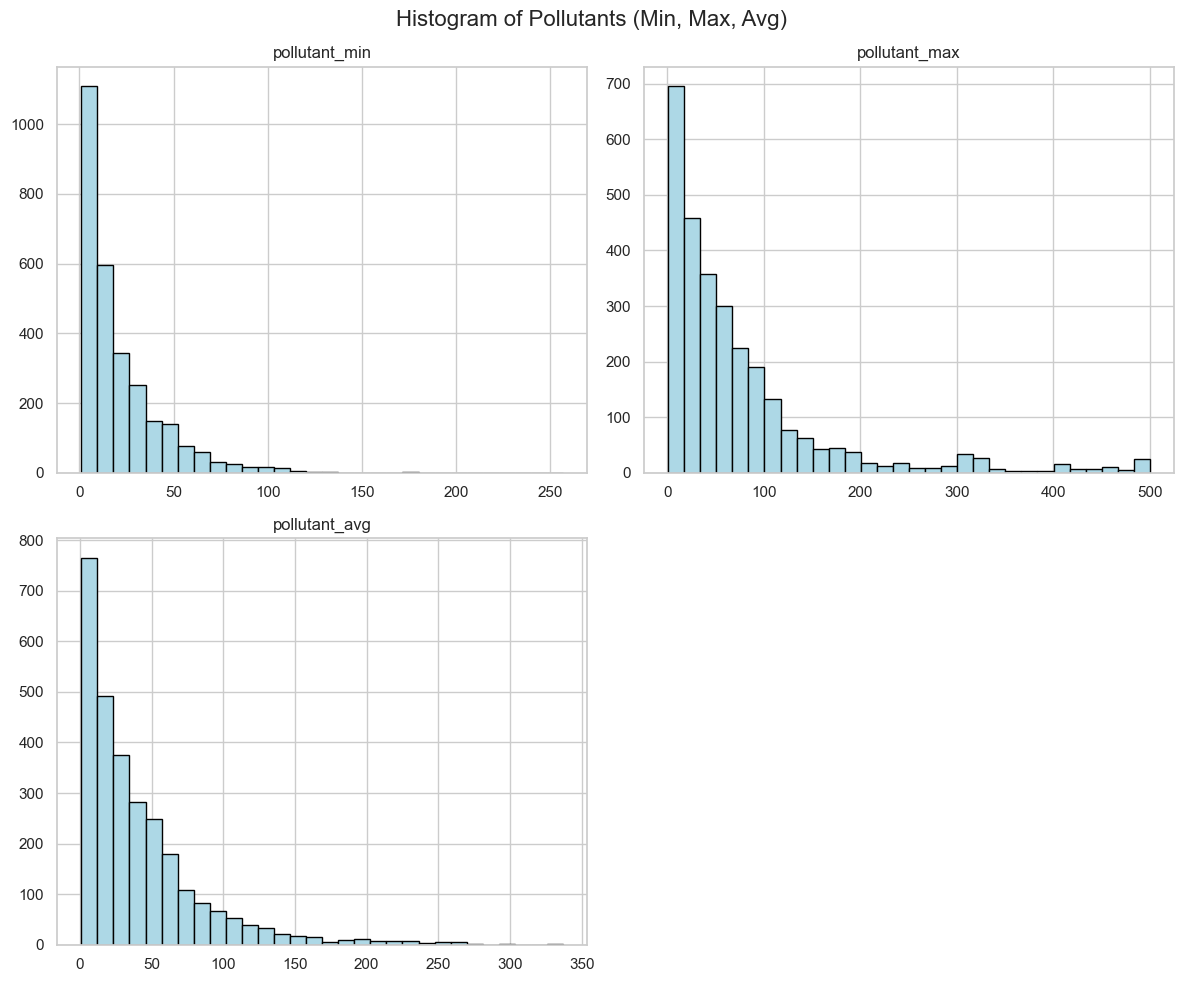

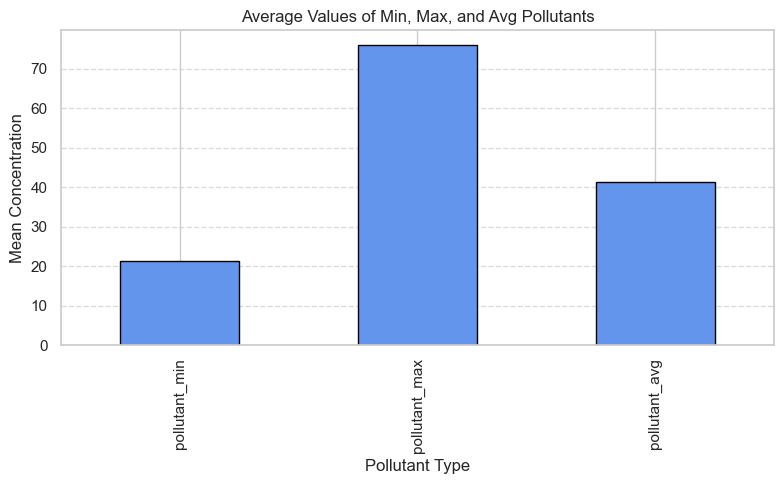

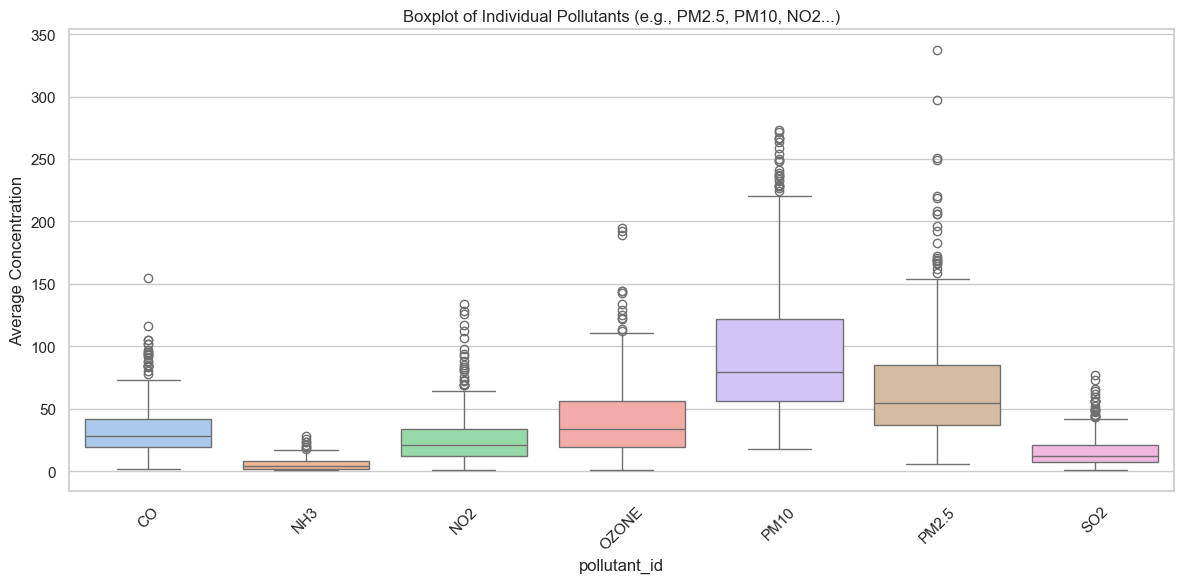

In [3]:
columns = ['pollutant_min', 'pollutant_max', 'pollutant_avg']
cols = [col for col in columns if col in df.columns]

sns.set(style="whitegrid")


df[cols].hist(figsize=(12, 10), bins=30, color='lightblue', edgecolor='black')
plt.suptitle("Histogram of Pollutants (Min, Max, Avg)", fontsize=16)
plt.tight_layout()
plt.show()

pollutant_means = df[cols].mean().round(2)

plt.figure(figsize=(8, 5))
pollutant_means.plot(kind='bar', color='cornflowerblue', edgecolor='black')

plt.title("Average Values of Min, Max, and Avg Pollutants")
plt.ylabel("Mean Concentration")
plt.xlabel("Pollutant Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


pivot_df = df.pivot_table(
    index=['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude'],
    columns='pollutant_id',
    values='pollutant_avg'
).reset_index()


pollutant_cols = pivot_df.columns.difference(['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude'])


plt.figure(figsize=(12, 6))
sns.boxplot(data=pivot_df[pollutant_cols], palette="pastel")
plt.title("Boxplot of Individual Pollutants (e.g., PM2.5, PM10, NO2...)")
plt.ylabel("Average Concentration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analyze Correlation Between Pollutants and AQI

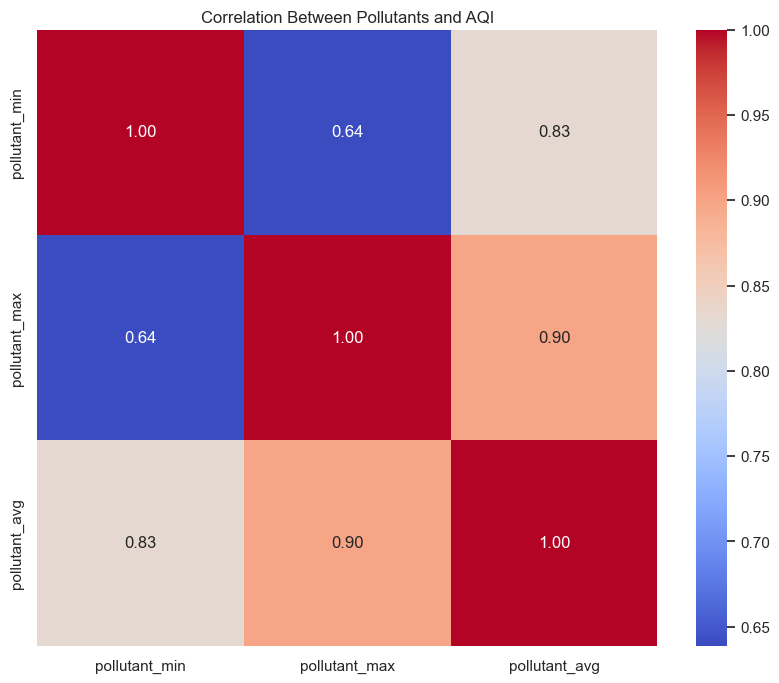

AQI column not found in dataset.


In [4]:
columns = ['pollutant_min', 'pollutant_max', 'pollutant_avg']

cols = [col for col in columns if col in df.columns]
df_filtered = df[cols].dropna()


corr_matrix = df_filtered.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Pollutants and AQI")
plt.show()

if 'AQI' in corr_matrix.columns:
    print("Correlation of Pollutants with AQI:\n")
    print(corr_matrix['AQI'].drop('AQI').sort_values(ascending=False))
else:
    print("AQI column not found in dataset.")

Compare Air Quality Across Locations

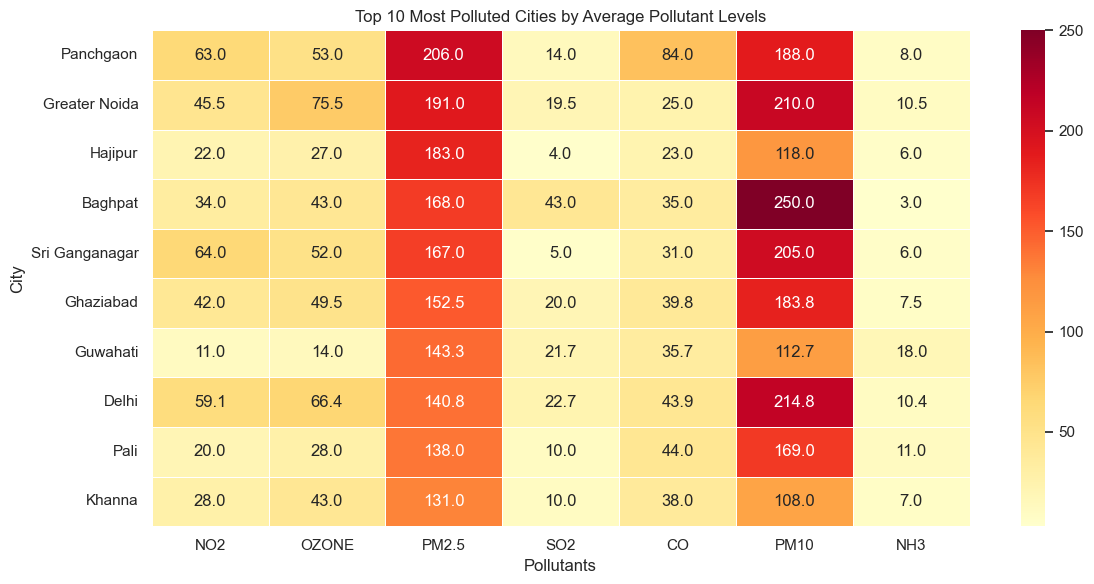

In [5]:
pollutants = df['pollutant_id'].unique()

pivot_df = df.pivot_table(index=['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude'],
                          columns='pollutant_id', values='pollutant_avg').reset_index()



city_pollution = pivot_df.groupby('city')[pollutants].mean().sort_values('PM2.5', ascending=False)


top_cities = city_pollution.head(10)


plt.figure(figsize=(12, 6))
sns.heatmap(top_cities, annot=True, cmap='YlOrRd', fmt=".1f", linewidths=0.5)
plt.title('Top 10 Most Polluted Cities by Average Pollutant Levels')
plt.ylabel('City')
plt.xlabel('Pollutants')
plt.tight_layout()
plt.show()

Explore Time-Based Trends in Air Quality

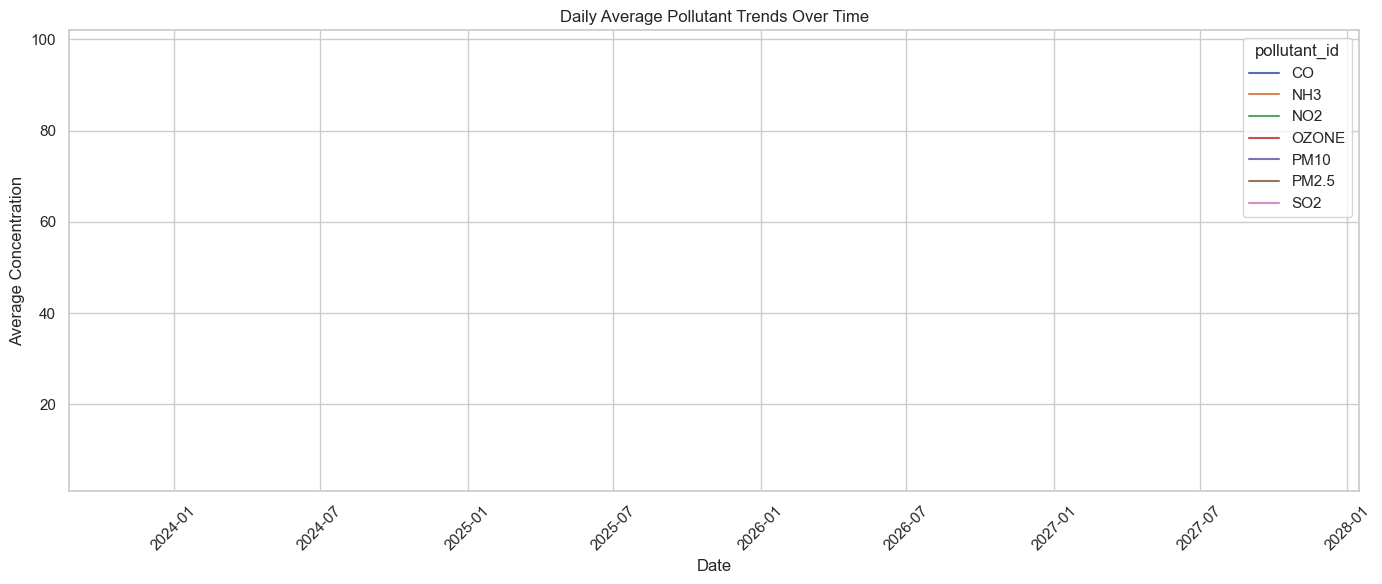

In [6]:
df['last_update'] = pd.to_datetime(df['last_update'], errors='coerce')


df = df.dropna(subset=['pollutant_avg', 'pollutant_id', 'last_update'])


daily_avg = df.groupby(['pollutant_id', pd.Grouper(key='last_update', freq='D')])['pollutant_avg'].mean().reset_index()


plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_avg, x='last_update', y='pollutant_avg', hue='pollutant_id')
plt.title("Daily Average Pollutant Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Average Concentration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

T-Test

In [7]:
def custom_t_test(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    n1, n2 = len(group1), len(group2)

    t_stat = (mean1 - mean2) / np.sqrt(var1/n1 + var2/n2)
    return t_stat


city1 = "Delhi"
city2 = "Mumbai"

group1 = df[(df['city'] == city1) & (df['pollutant_id'] == 'PM2.5')]['pollutant_avg']
group2 = df[(df['city'] == city2) & (df['pollutant_id'] == 'PM2.5')]['pollutant_avg']

t_stat = custom_t_test(group1, group2)
print(f"\nT-Test between {city1} and {city2} PM2.5 levels:\nT-statistic = {t_stat:.2f}")


T-Test between Delhi and Mumbai PM2.5 levels:
T-statistic = 13.81


Z-Test

In [8]:
def custom_z_test(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1), np.std(group2)
    n1, n2 = len(group1), len(group2)

    z_stat = (mean1 - mean2) / np.sqrt(std1**2/n1 + std2**2/n2)
    return z_stat


z_stat = custom_z_test(group1, group2)
print(f"\nZ-Test between {city1} and {city2} PM2.5 levels:\nZ-statistic = {z_stat:.2f}")


Z-Test between Delhi and Mumbai PM2.5 levels:
Z-statistic = 14.02


Chi-Square Test

In [9]:
df['pollution_level'] = pd.qcut(df[df['pollutant_id'] == 'PM2.5']['pollutant_avg'], q=2, labels=['Low', 'High'])


contingency = pd.crosstab(df['state'], df['pollution_level'])


observed = contingency.values
expected = np.outer(observed.sum(axis=1), observed.sum(axis=0)) / observed.sum()

chi2_stat = ((observed - expected)**2 / expected).sum()

print("\nChi-Square Test (State vs PM2.5 Pollution Level):")
print(f"Chi-Square Statistic: {chi2_stat:.2f}")


Chi-Square Test (State vs PM2.5 Pollution Level):
Chi-Square Statistic: 116.66
